In [1]:
# Importamos las librerías estandar para empezar a trabajar con los dataframes 
import pandas as pd
import numpy as np
from siuba import *
from plotnine import *

In [2]:
######### Importar datos ##########
# Los datos sobre los tumores benignos y malignos
mi_data = pd.read_csv('https://raw.githubusercontent.com/scidatmath2020/ML_Py_23/main/data/cancer_mama.csv')

In [3]:
######### Regresión logistíca ##########
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Cambiamos el valor original tumor_maligno=0 --> tumor_maligno=1
# También hacemos tumor_benigno=0 --> tumor_benigno=0
mi_data = mi_data >> mutate(diagnosis=_.diagnosis.replace({0:1, 1:0}))

# definimos como X al dataframe con los valores independientes
X = mi_data >> select(-_.diagnosis)

# definimos como y al dataframe con los valores objetivo
y =  mi_data >> select(_.diagnosis)

# separamos las tablas anteriores en tablas de entrenamiento (train)
# y en tablas de validación (val)
# Con test_size=0.25, seleccionamos el 25% de los datos como validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2023)

In [4]:
# Definimos el modelo de la regresión logística
model_lr = LogisticRegression(solver = "newton-cholesky")
# Entrenamos el modelo
model_lr.fit(X_train, y_train.values.ravel())
# Hacemos las predicciones usando los valores para la validación
pred_lr = model_lr.predict(X_val)
# Calculamos las probabilidades de los resultados anteriores
pred_prob = model_lr.predict_proba(X_val)

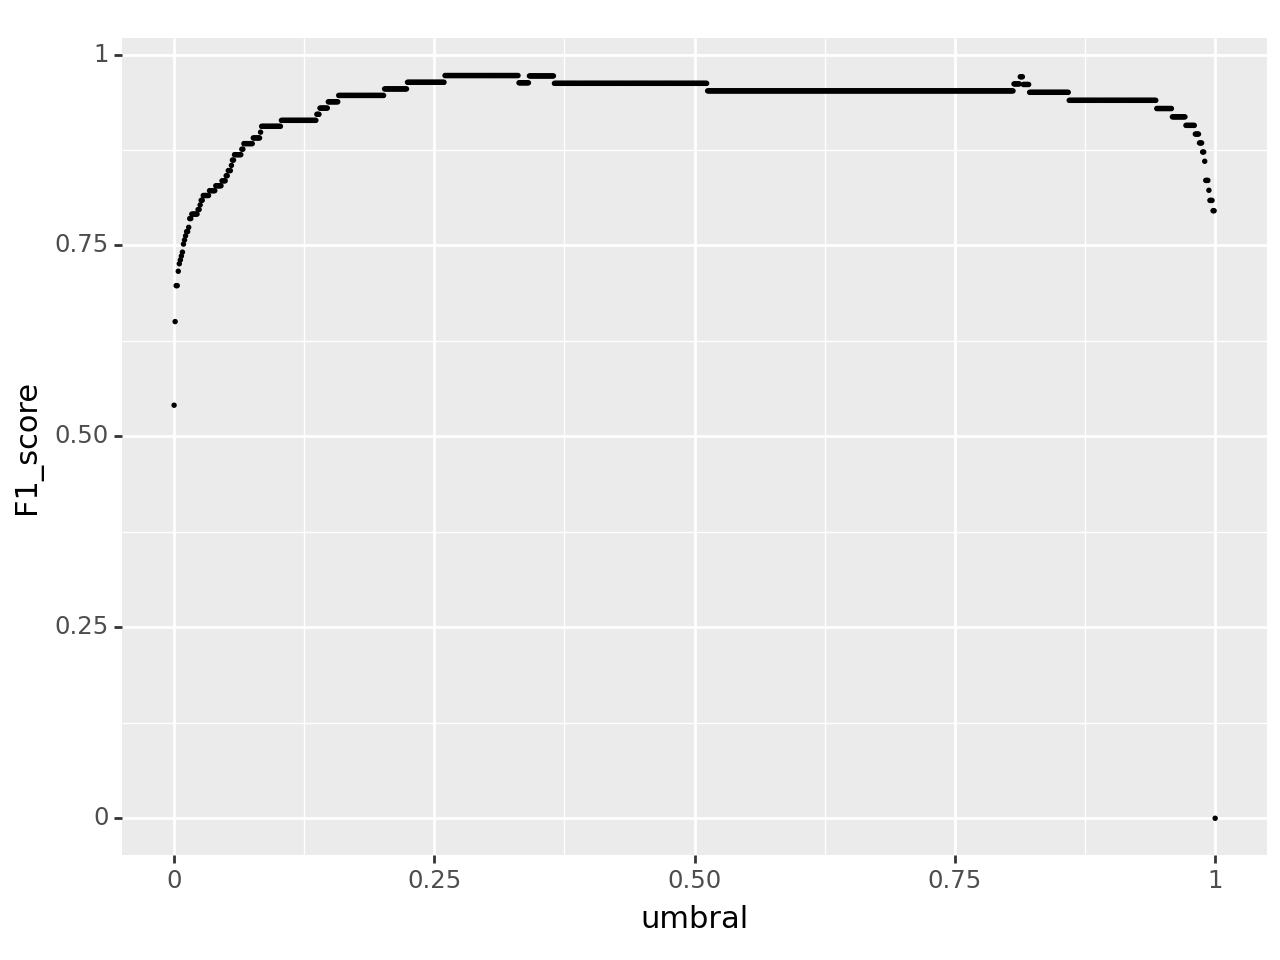

<Figure Size: (640 x 480)>

In [5]:
# Lo siguiente son los métodos y funciones que usamos
# para evaluar la puntuación F1 acorde al umbral estadístico.
# Lo anterior para el modelo de regresión logística de la clase 7

def prob_etiqueta(pred_proba, umbral=0.5):
    predicciones = np.zeros([len(pred_proba), ])
    predicciones[pred_proba[:, 1]>=umbral] = 1
    return predicciones

def evaluar_umbral(umbral):
    pred_umbral = prob_etiqueta(pred_prob, umbral)
    F1_umbral = metrics.f1_score(y_val, pred_umbral)
    return (umbral, F1_umbral)

umbral_eval = pd.DataFrame([evaluar_umbral(x) for x in np.linspace(0., 1., 1000)],
                            columns = ["umbral", "F1_score"])

(ggplot(data=umbral_eval) +
    geom_point(mapping=aes(x="umbral", y="F1_score"), size=0.1)
)

In [6]:
# Finalmente guardamos el máximo valor de la puntuación F1 que hayamos
# encontrado en nuestra tabla 'umbral_eval'
max_lr = umbral_eval['F1_score'].max()
max_lr

0.9724770642201834

In [7]:
# Ahora calculamos la puntuación F1 del modelo de regresión lineal
#metrics.f1_score(y_val, pred_lr)

######### KN vecinos ##########

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# La siguiente función nos calcula la puntuación F1 usando
# KN con peso uniforme y peso distancias, en función del 
# número de K vecinos. 
def clasificadores_knn(k):
    knn_uniform = KNeighborsClassifier(n_neighbors=k, weights="uniform")
    knn_distance = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn_uniform.fit(X_train, y_train)
    knn_distance.fit(X_train, y_train)
    pred_uniform = knn_uniform.predict(X_val.values)
    pred_distance = knn_distance.predict(X_val.values)
    f1_uniform = f1_score(y_val, pred_uniform, average="micro")
    f1_distance = f1_score(y_val, pred_distance, average="micro")
    return (k, f1_uniform, f1_distance)

c:\Users\wikki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\Users\wikki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\Users\wikki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
c:\Users\wikki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
c:\Users\wikki\AppData\Local\Programs\Python\Python311\Lib\sit

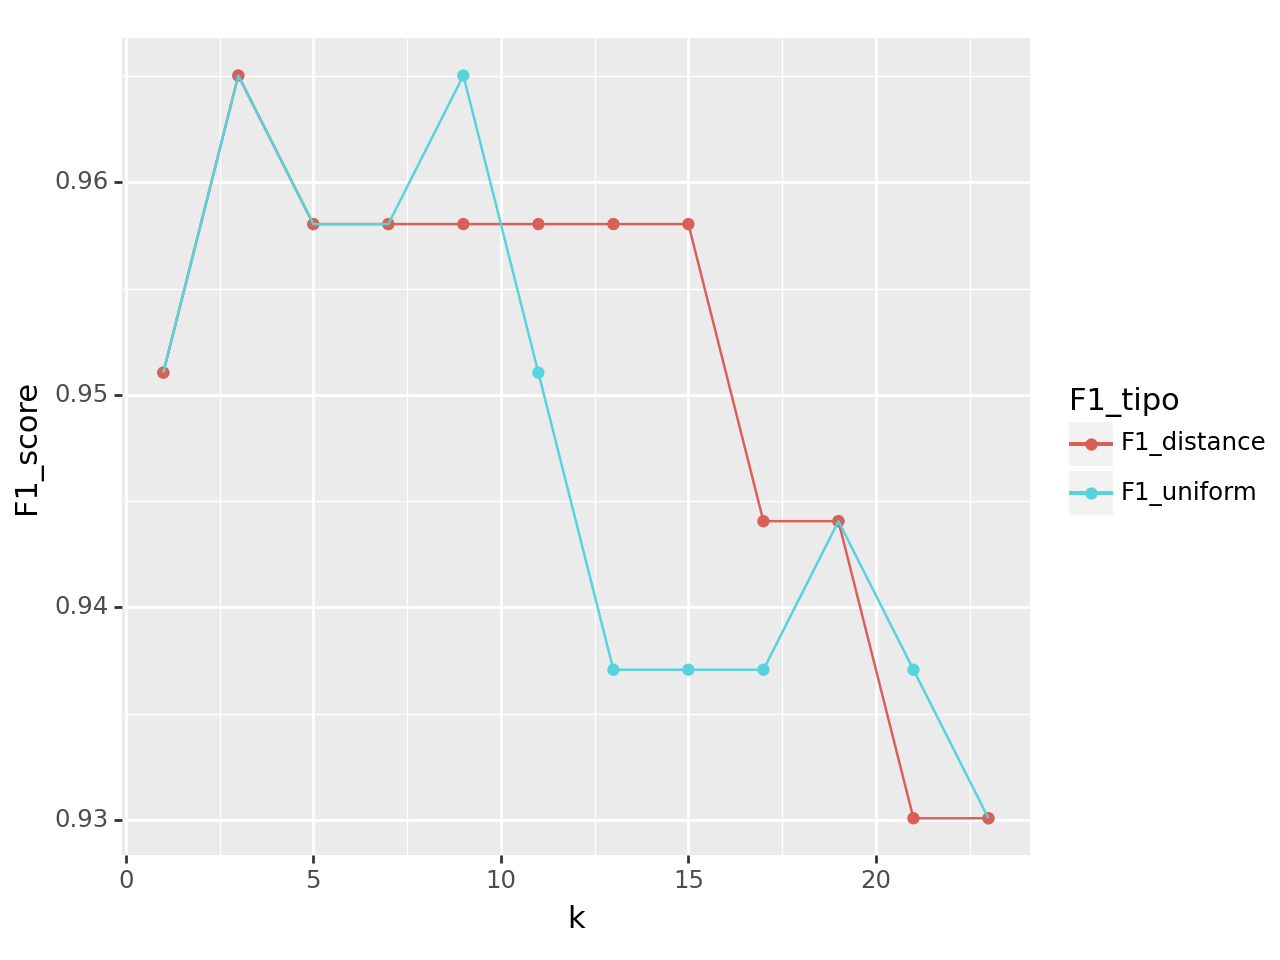

In [8]:
# Importamos math para usar la función ceil
import math
# Definimos el límite máximo del número de K vecinos a evaluar
k_lim = math.ceil(mi_data.shape[0]**0.5)
# Hacemos una lista con las salidas de la función 'clasificadores_knn'
knn_eval =[clasificadores_knn(k) for k in range(1, k_lim, 2)]
# Convertimos la lista anterior a dataframe
knn_eval = pd.DataFrame(knn_eval, columns = ["k","F1_uniform", "F1_distance"])
# Convertimos el dataframe anterior a otro del tipo 'tidy', lo que nos
# facilita graficas.
knn_eval_tidy = knn_eval >> gather("F1_tipo", "F1_score", -_.k)
# Graficamos los valores de la función 'clasificadores_knn'
print(ggplot(data = knn_eval_tidy) +
    geom_point(mapping=aes(x="k", y="F1_score", color="F1_tipo")) +
    geom_line(mapping=aes(x="k", y="F1_score", color="F1_tipo"))
)

In [9]:
#Escogemos el valor máximo de la puntuación F1 para cada método
max_knn_uniform =  knn_eval['F1_uniform'].max()
max_knn_distance = knn_eval['F1_distance'].max()

# Hacemos una lista con el nombre del modelo usado y el valor
# máximo de la puntuación F1 obtenida
max_list = [['Logistic Regression', max_lr], 
            ['KNN uniforme', max_knn_uniform], 
            ['KNN distancia', max_knn_distance]]

# Convertimos esa lista a DataFrame
max_dt = pd.DataFrame(max_list, columns=['Modelo', 'max_F1'])
max_dt

,Modelo,max_F1
0,Logistic Regression,0.972477
1,KNN uniforme,0.965035
2,KNN distancia,0.965035
